In [1]:
from __future__ import annotations

import json
import os
import pickle
from dataclasses import dataclass
from typing import Final

from matplotlib import pyplot as plt
from tqdm import tqdm

import numpy as np

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from PIL import Image, ImageFilter, ImageFont

import character_utility as charutil
import config
from ipywidgets_helper import render_images
from kvg import Kvg
from utility import pathstr, char2code, create_vertical_stack_image

In [2]:
@dataclass
class PreparedKvg():
    root: Final[Kvg]
    decomposition: Final[dict[str, Kvg]]
    features: Final[dict[str, np.ndarray]]
    images_for_sample: Final[dict[str, Image.Image]]


def prepare_kvg(char: str, image_size: int, stroke_width: float, log=False):
    charcode = char2code(char)
    directory_path = config.output_main_kvg_path(charcode)
    with open(pathstr(directory_path, f"{charcode}.json")) as f:
        root_kvg = Kvg.from_dict(json.load(f))
    
    if log: print(json.dumps(root_kvg.to_dict(), ensure_ascii=False, indent=2))

    def dfs(kvg: Kvg) -> list[Kvg]:
        ret: list[Kvg] = []
        if len(kvg.svg) == 0:
            for kvg0 in kvg.children:
                ret0 = dfs(kvg0)
                if len(ret0) == 0:
                    ret.clear()
                    break
                ret += ret0
        if len(ret) == 0:
            if kvg.name is not None:
                ret.append(kvg)

        return ret

    decomposition = {kvg.kvgid: kvg for kvg in dfs(root_kvg)}

    def get_feature_from_image(image):
        image = image.filter(ImageFilter.GaussianBlur(2))
        image = np.array(image)
        feature = np.concatenate((image.reshape(-1), image.transpose().reshape(-1))) # 一方向だけだと例えば「かんむり」と「たれ」が区別されにくい
        return feature

    images_for_features: dict[str, Image.Image] = {}
    features: dict[str, np.ndarray] = {}
    images_for_sample: dict[str, Image.Image] = {}
    for kvgid in decomposition.keys():
        images_for_features[kvgid] = Image.open(pathstr(
            directory_path,
            f"{image_size}x,pad=0,sw={stroke_width} {kvgid}.png",
        ))
        features[kvgid] = get_feature_from_image(images_for_features[kvgid])
        images_for_sample[kvgid] = Image.open(pathstr(
            directory_path,
            f"64x,pad=4,sw=2 {kvgid}.png", # 雑
        ))

    pkvg = PreparedKvg(
        root=root_kvg,
        decomposition=decomposition,
        features=features,
        images_for_sample=images_for_sample,
    )
    return pkvg, images_for_features


def test():
    pkvg, images_for_features = prepare_kvg("遠", 16, 2, log=True)

    images = []
    for kvgid, image in pkvg.images_for_sample.items():
        images.append((image, kvgid))
    for kvgid, image in images_for_features.items():
        images.append((image, kvgid))
    return render_images(images, columns=(len(images) // 2))


test()

{
  "kvgid": "09060",
  "name": "遠",
  "part": null,
  "position": null,
  "svg": [],
  "children": [
    {
      "kvgid": "09060-g1",
      "name": "袁",
      "part": null,
      "position": "nyoc",
      "svg": [],
      "children": [
        {
          "kvgid": "09060-g2",
          "name": "土",
          "part": null,
          "position": "top",
          "svg": [
            "M45.82,23.35c1.16,0.32,3.27,0.47,4.43,0.32c6.16-0.8,16.04-2.18,22.01-2.9c1.92-0.23,3.08,0.16,4.04,0.32",
            "M59.23,10.62c0.89,0.89,1.61,2.38,1.61,4.07c0,9.57-0.06,16.66-0.06,17.81"
          ],
          "children": [
            {
              "kvgid": "09060-g3",
              "name": "衣",
              "part": "1",
              "position": null,
              "svg": [],
              "children": [
                {
                  "kvgid": "09060-g4",
                  "name": "亠",
                  "part": null,
                  "position": null,
                  "svg": [
               

GridBox(children=(VBox(children=(Label(value='09060-g2'), Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x0…

data size: 2825
pca.explained_variance_ratio_=array([0.3478533, 0.2647191])


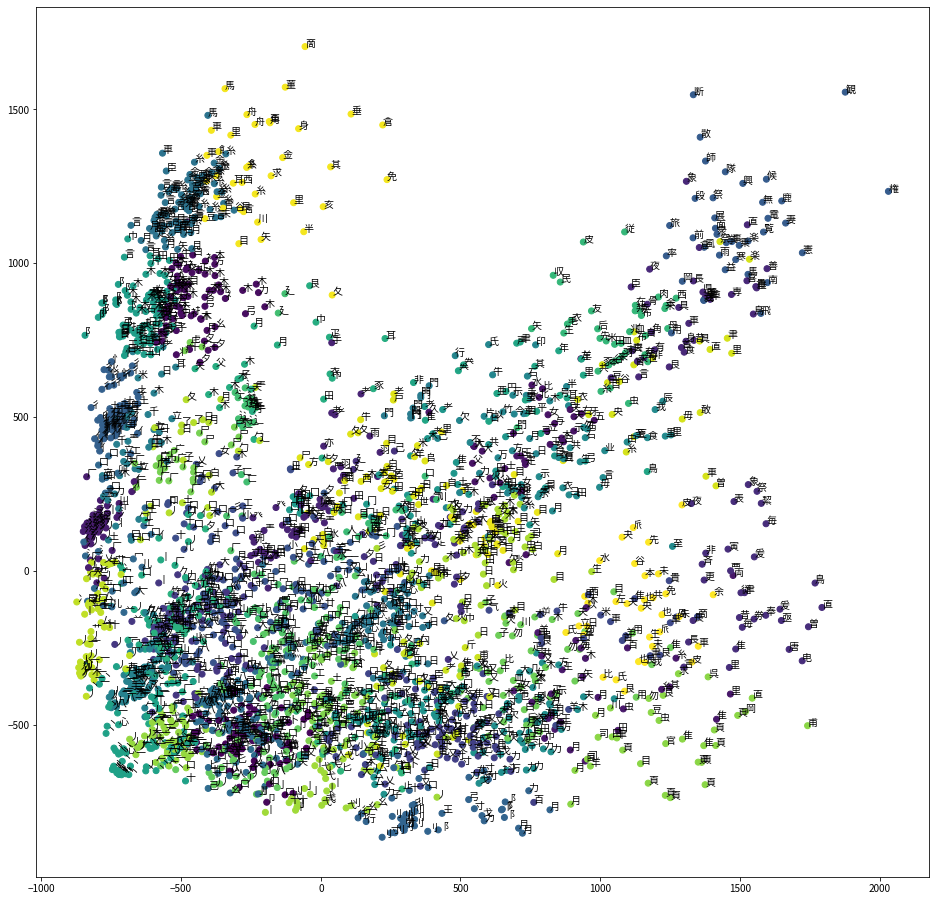

In [3]:
@dataclass(frozen=True)
class KMeansResult:
    kvgs: list[Kvg]
    features: np.ndarray
    labels: list[int]
    kmeans: KMeans


def train_kmeans(pkvgs: list[PreparedKvg], n_clusters, log=False, plot=False) -> KMeansResult:
    kvgs: list[Kvg] = []
    features = []
    for pkvg in pkvgs:
        for kvgid, feature in pkvg.features.items():
            kvgs.append(pkvg.decomposition[kvgid])
            features.append(feature)
    features = np.stack(features)

    if log: print(f"data size: {len(kvgs)}")

    kmeans = KMeans(n_init=4, n_clusters=n_clusters, init="k-means++")
    labels = kmeans.fit_predict(features).tolist()
    
    if plot:
        pca = PCA(n_components=2)
        boundings2d = pca.fit_transform(features)
        print(f"{pca.explained_variance_ratio_=}")

        plt.figure(figsize=(16, 16))
        plt.scatter(boundings2d[:, 0], boundings2d[:, 1], c=labels)
        for kvg, xy in zip(kvgs, boundings2d):
            assert kvg.name is not None
            plt.annotate(kvg.name, xy)
    
    return KMeansResult(kvgs=kvgs, features=features, labels=labels, kmeans=kmeans)


def test(characters, n_clusters, image_size, stroke_width):
    pkvgs = [prepare_kvg(c, image_size, stroke_width)[0] for c in characters]
    train_kmeans(pkvgs, n_clusters=n_clusters, log=True, plot=True)


test(charutil.kanjis.education(), n_clusters=64, image_size=16, stroke_width=2)

100%|███████████████████████████████████████████████████████████████████████████████| 32/32 [06:20<00:00, 11.89s/it]


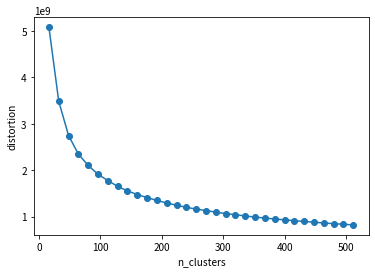

In [4]:
def plot_elbow(characters, n_clusters_candidates, image_size=16, stroke_width=2):
    pkvgs = [prepare_kvg(c, image_size, stroke_width)[0] for c in characters]

    distortions = []
    for n_clusters in tqdm(n_clusters_candidates):
        result = train_kmeans(pkvgs, n_clusters=n_clusters, log=False)
        distortions.append(-result.kmeans.score(result.features))

    plt.plot(n_clusters_candidates, distortions, marker="o")
    plt.xlabel("n_clusters")
    plt.ylabel("distortion")


plot_elbow(charutil.kanjis.all(), range(16, 512 + 1, 16))

In [5]:
def save(characters, dataset_name, n_clusters, image_size, stroke_width, n_sample_images):
    directory_path = pathstr(
        config.output_radical_clustering_path,
        f"{dataset_name} n_clusters={n_clusters} (imsize={image_size},sw={stroke_width})"
    )
    os.makedirs(directory_path, exist_ok=False)
    
    pkvgs = [prepare_kvg(c, image_size, stroke_width)[0] for c in characters]
    result = train_kmeans(pkvgs, n_clusters=n_clusters, log=True)

    with open(pathstr(directory_path, "kmeans.pickle"), "wb") as f:
        pickle.dump(result.kmeans, f)

    # label2kvgids
    label2kvgids = [[] for _ in range(n_clusters)]
    for kvg, label in zip(result.kvgs, result.labels):
        label2kvgids[label].append(kvg.kvgid)
    for t in label2kvgids:
        t.sort()

    with open(pathstr(directory_path, "label2kvgids.json"), "w") as f:
        json.dump(label2kvgids, f)

    # cluster_samples_image
    kvgid2label = {kvg.kvgid: label for kvg, label in zip(result.kvgs, result.labels)}

    label2images: list[list[Image.Image]] = [[] for _ in range(n_clusters)]
    for pkvg in pkvgs:
        for kvgid, image in pkvg.images_for_sample.items():
            label2images[kvgid2label[kvgid]].append(image)

    n_clusters_digit = len(str(n_clusters))

    image_data_list = []
    for i in range(n_clusters):
        center = result.kmeans.cluster_centers_[i]
        center_image = (center[:(image_size ** 2)].reshape(image_size, image_size) + center[(image_size ** 2):].reshape(image_size, image_size).transpose()) / 2
        center_image = Image.fromarray(center_image)
        center_image = center_image.resize(label2images[i][0].size)

        sample_images = label2images[i][:n_sample_images]

        image_data_list.append("    ".join((f"{str(i).zfill(n_clusters_digit)}", f"radicals: {len(label2images[i])}")))
        image_data_list.append([center_image, *sample_images])

    cluster_samples_image = create_vertical_stack_image(
        image_data_list,
        gap=8,
        font=ImageFont.truetype(config.font_path, size=24, index=0),
    )
    cluster_samples_image.save(pathstr(directory_path, "cluster-samples.png"))

    return render_images([cluster_samples_image])

# save(charutil.kanjis.jis_row(16), "test", n_clusters=16, image_size=16, stroke_width=2, n_sample_images=16)
save(charutil.kanjis.all(), "edu+jis_L1,2", n_clusters=256, image_size=16, stroke_width=2, n_sample_images=16)

data size: 21010


GridBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\xd0\x00\x00m\x08\x08\x02\x00\x…